In [1]:
!python --version
#%pip install numpy pandas matplotlib seaborn scikit-learn statsmodels mesa gpboost tqdm

Python 3.12.2


In [2]:
import os
import pandas as pd
import numpy as np
# import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib
from scipy import stats
import statsmodels.api as sm
from functools import reduce
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
# import gpboost as gpb
from scipy.stats import ttest_ind
from scipy.stats import spearmanr
from tqdm import tqdm
import gpboost as gpb

plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = "Helvetica"

# Simulation

In [3]:
def gradient_descent_update(x_sample, y_sample, beta, learning_rate):
    """
    Perform one step of gradient descent using one sample

    :param x_sample: single feature vector
    :param y_sample: actual value for the given feature vector
    :param beta: current coefficients
    :param learning_rate: step size for update
    :return: updated coefficients
    """
    y_pred = x_sample.dot(beta)
    gradient = -2 * x_sample.T * (y_sample - y_pred)
    beta -= learning_rate * gradient
    return beta

def mean_squared_error(true_beta, estimated_beta):
    return np.mean((true_beta - estimated_beta) ** 2)

def euclidean_distance(true_beta, estimated_beta):
    return np.linalg.norm(true_beta - estimated_beta)

In [4]:
class ConformityAgent(Agent):
    def __init__(self, unique_id, model, t_birth, *, lifespan, p_learn, conformity, sensitivity):
        super().__init__(unique_id, model)
        self.beta = np.random.uniform(0, 1, size=self.model.n_dim)
        self.cum_performance = 0
        self.t_birth = t_birth
        self.lifespan = lifespan
        self.p_learn = p_learn
        self.conformity = conformity
        self.sensitivity = sensitivity

    def step(self):
        # x, y = self.model.current_x, self.model.current_y
        self.pred_y = self.model.current_x.dot(self.beta)

        # Learning from environments
        if np.random.uniform(0, 1) < self.p_learn:
            self.beta = gradient_descent_update(self.model.current_x, self.model.current_y, self.beta, self.model.learning_rate)

        # Conformity behavior (none, shallow or deep)
        if (self.conformity != "None"):
            if "Asymmetric" in self.conformity:
                tgt_agents = [agent for agent in self.model.schedule.agents if (agent != self) & (agent.t_birth < self.t_birth)]
            elif "Symmetric" in self.conformity:
                tgt_agents = [agent for agent in self.model.schedule.agents if (agent != self)]
            if len(tgt_agents) > 0:
                tgt_agent = np.random.choice(tgt_agents)
                tgt_pred_y = self.model.current_x.dot(tgt_agent.beta)
                self.pred_y += (tgt_pred_y - self.pred_y) * self.sensitivity # conform about this specific problem
                if ("Deep" in self.conformity):
                    self.beta += (tgt_agent.beta - self.beta) * self.sensitivity # comform about beta

        self.cum_performance += performance(self)
        self.lifespan -= 1
        if self.lifespan < 0: # exit if the lifespan has passed
            self.model.schedule.remove(self)

# Convenient functions
def beta_gap(agent):
    return euclidean_distance(agent.model.true_beta, agent.beta)


def performance(agent):
    return - (agent.pred_y - agent.model.current_y) ** 2

            
# Model            
class GenerationModel(Model):
    def __init__(
        self, *, 
        n_dim, # Number of dimensions of the feature space
        learning_rate, # Learning rate when learning directly about the environment
        lifespan, # Lifespan of an agent
        p_learn, # Probability of direct learning
        conformity, # Conformity Type
        sensitivity, # Sensitivity of conformity (both at shallow and deep levels)
        gen_interval, # Interbval between generations; lifespan - gen_interval defines the number of timesteps where an agent learn by themselves alone
        n_agents_per_gen, # Number of agents per generation
        seed=0
    ):
        np.random.seed(seed)
        self.schedule = RandomActivation(self)
        self.n_dim = n_dim
        self.learning_rate = learning_rate
        self.lifespan = lifespan
        self.p_learn = p_learn
        self.conformity = conformity
        self.sensitivity = sensitivity
        self.gen_interval = gen_interval
        self.n_agents_per_gen = n_agents_per_gen

        self.true_beta = np.random.uniform(0, 1, size=self.n_dim)
        self.datacollector = DataCollector(
            agent_reporters={"t_birth": "t_birth", "beta_gap": beta_gap, "performance": performance, "cum_performance": "cum_performance"}
        )
        self.n_agents = 0

    def step(self):
        # Generate new x and y
        self.current_x = np.random.uniform(0, 1, size=self.n_dim)
        self.current_y = self.current_x.dot(self.true_beta)

        # Create a new generation of agents
        if self.schedule.steps % self.gen_interval == 0:
            for i in range(self.n_agents_per_gen):
                a = ConformityAgent(
                    unique_id=self.n_agents,
                    model=self,
                    t_birth=self.schedule.steps,
                    lifespan=self.lifespan,
                    p_learn=self.p_learn,
                    conformity=self.conformity,
                    sensitivity=self.sensitivity
                )
                self.schedule.add(a)
                self.n_agents += 1

        self.schedule.step()
        self.datacollector.collect(self)

In [5]:
def main_simulation(param, param_list):
    model_args = dict(
        n_dim=40,
        learning_rate=.05,
        lifespan=20,
        p_learn=1,
        conformity='uni-deep',
        sensitivity=.3,
        gen_interval=10,
        n_agents_per_gen=10,
        seed=1
    )
    
    res_list = []
    
    for p in tqdm(param_list):
        model_args[param] = p
        model_dict = {}
        for cond_name in ['None', 'Shallow & Symmetric', 'Shallow & Asymmetric', 'Deep & Symmetric', 'Deep & Asymmetric']:
            model_args['conformity'] = cond_name
            model = GenerationModel(**model_args)
            for t in range(400):
                model.step()
            model_dict[cond_name] = model
        res = {
            'model_dict': model_dict,
            'param_name': param,
            'param': param_list,
            'res_list': res_list
        }
        res_list.append(res)
    
    output = {
        'param_name': param,
        'param': param_list,
        'res_list': res_list
    }
    
    return output

In [6]:
sim_100times = main_simulation('seed', range(100))

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/zh/h1khb7411lv13bh3mcjtr4d80000gn/T/ipykernel_26882/1546748411.py:3: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


100%|██████████| 100/100 [16:47<00:00, 10.07s/it]


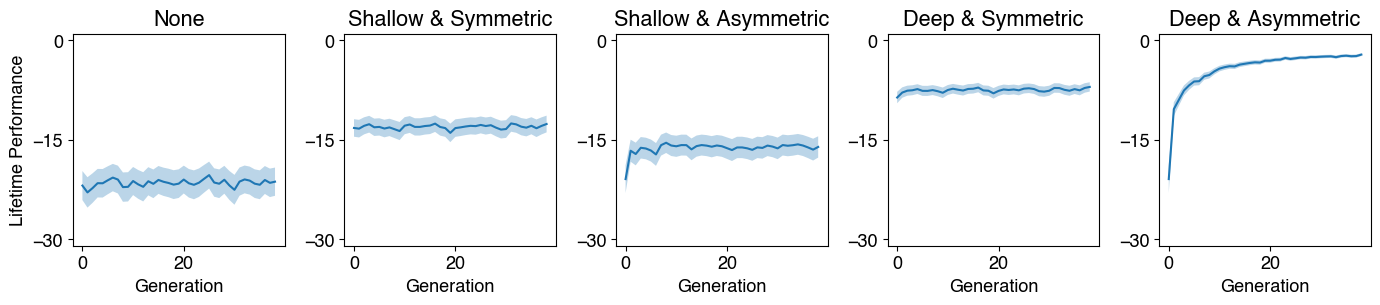

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(14, 3))
for ax, (cond_name, model) in zip(axes, sim_100times['res_list'][0]['model_dict'].items()):
    ax.set_box_aspect(1)
    y = []
    for i in range(100):
        result_df = sim_100times['res_list'][i]['model_dict'][cond_name].datacollector.get_agent_vars_dataframe().reset_index()
        result_df['age'] = result_df.Step - result_df.t_birth
        cum_performance_per_gen = result_df[lambda x: x.age == 20].groupby("t_birth")['cum_performance'].mean()
        y.append(cum_performance_per_gen.values)

    d = pd.DataFrame({
        "x": cum_performance_per_gen.index / 10,
        "y": reduce(lambda a, b: a + b, y) / len(y), # calculate mean of 50 simulations
        "err": reduce(lambda a, b: a + b, y) / len(y) / np.sqrt(len(y)) # calculate standard error of mean
    })
    
    # ax.scatter(x, y, label=cond_name, marker="+", alpha=.7)
    sns.lineplot(d, x="x", y="y", ax=ax, label=cond_name, legend=False)
    ax.fill_between(d.x, d.y - d.err, d.y + d.err, alpha=.3)

    ax.set_title(cond_name)
    ax.set_ylim(-31, 1)
    ax.set_yticks([0, -15, -30])
    # ax.legend(bbox_to_anchor=(1, 1), frameon=False)
    ax.set_xlabel("Generation")
    if cond_name == 'None':
        ax.set_ylabel("Lifetime Performance")
    else:
        ax.set_ylabel("")
        
plt.tight_layout()
plt.savefig("img/lifetime-performance.pdf")
plt.show()
plt.close()


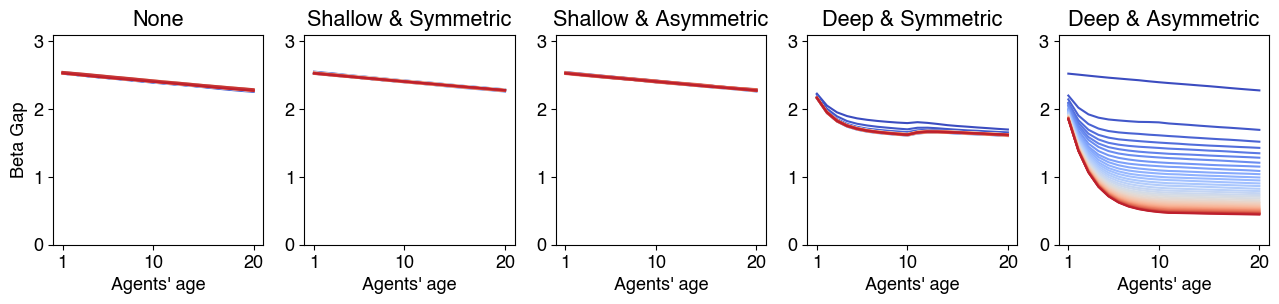

In [8]:
fig, axes = plt.subplots(1, 5, figsize=(13, 3))

cmap = plt.cm.coolwarm #Oranges
N = 39
for ax, (cond_name, model) in zip(axes, sim_100times['res_list'][0]['model_dict'].items()):
    ax.set_box_aspect(1)
    
    beta_gap_per_gen_list = []
    for i in range(100):
        result_df = sim_100times['res_list'][i]['model_dict'][cond_name].datacollector.get_agent_vars_dataframe().reset_index()
        result_df['age'] = result_df.Step - result_df.t_birth
        beta_gap_per_gen_list.append(result_df.groupby(['t_birth', 'age'])['beta_gap'].mean().unstack())
    
    beta_gap_per_gen = pd.concat(beta_gap_per_gen_list).groupby(level=0).mean()  # calculate mean of 50 simulations
    
    for t_birth, data in beta_gap_per_gen.head(N).iterrows():
        ax.plot(data, color=cmap(t_birth/N/10))
        
    ax.set_ylim(0, 3.1)
    ax.set_xticks([1, 10, 20])
    ax.set_title(cond_name)
    ax.set_xlabel("Agents' age")
    if cond_name == 'None':
        ax.set_ylabel('Beta Gap')

plt.tight_layout()
plt.savefig("img/beta-gap.pdf")
plt.show()
plt.close()


## Sensitivity Analysis

In [14]:
def sensitivity_analysis(param, param_list):
    model_args = dict(
        n_dim=40,
        learning_rate=.05,
        lifespan=20,
        p_learn=1,
        conformity='uni-deep',
        sensitivity=.3,
        gen_interval=10,
        n_agents_per_gen=10,
        seed=1
    )
    
    res_list = []
    
    for p in param_list:
        model_args[param] = p
        model_dict = {}
        for cond_name in ['None', 'Shallow & Symmetric', 'Shallow & Asymmetric', 'Deep & Symmetric', 'Deep & Asymmetric']:
            model_args['conformity'] = cond_name
            model = GenerationModel(**model_args)
            for t in range(500):
                model.step()
            model_dict[cond_name] = model
        res = {
            'model_dict': model_dict,
            'param_name': param,
            'param': param_list,
            'res_list': res_list
        }
        res_list.append(res)
    
    output = {
        'param_name': param,
        'param': param_list,
        'res_list': res_list
    }
    
    return output

In [15]:
def plot_sensitivity_analysis(result):
    length = len(result["res_list"])
    
    fig, axes = plt.subplots(length, 5, figsize=(15, 3*length))
    
    cmap = plt.cm.coolwarm#Oranges
    N = 48
    
    for row, res in enumerate(result['res_list']):
        for ax, (cond_name, model) in zip(axes[row], res["model_dict"].items()):
            ax.set_box_aspect(1)
            result_df = res["model_dict"][cond_name].datacollector.get_agent_vars_dataframe().reset_index()
            result_df['age'] = result_df.Step - result_df.t_birth
            beta_gap_per_gen = result_df.groupby(['t_birth', 'age'])['beta_gap'].mean().unstack()
            for t_birth, data in beta_gap_per_gen.head(N).iterrows():
                ax.plot(data, color=cmap(t_birth/N/10))
            ax.set_ylim(0, 3.1)
            ax.set_xticks([1, 10, 20])
            ax.text(20, 3, f'{res["param_name"]}={np.round(res["param"][row], 3)}', ha='right', va='top', fontsize=12, color='blue')
            if(row == 0):
                ax.set_title(cond_name)
            if(cond_name == 'None'):
                ax.set_ylabel('Beta Gap')
            if(row == length-1):
                ax.set_xlabel("Agents' Age")
                

    #plt.tight_layout()
    plt.show()
    plt.close()

/var/folders/zh/h1khb7411lv13bh3mcjtr4d80000gn/T/ipykernel_26882/1546748411.py:3: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


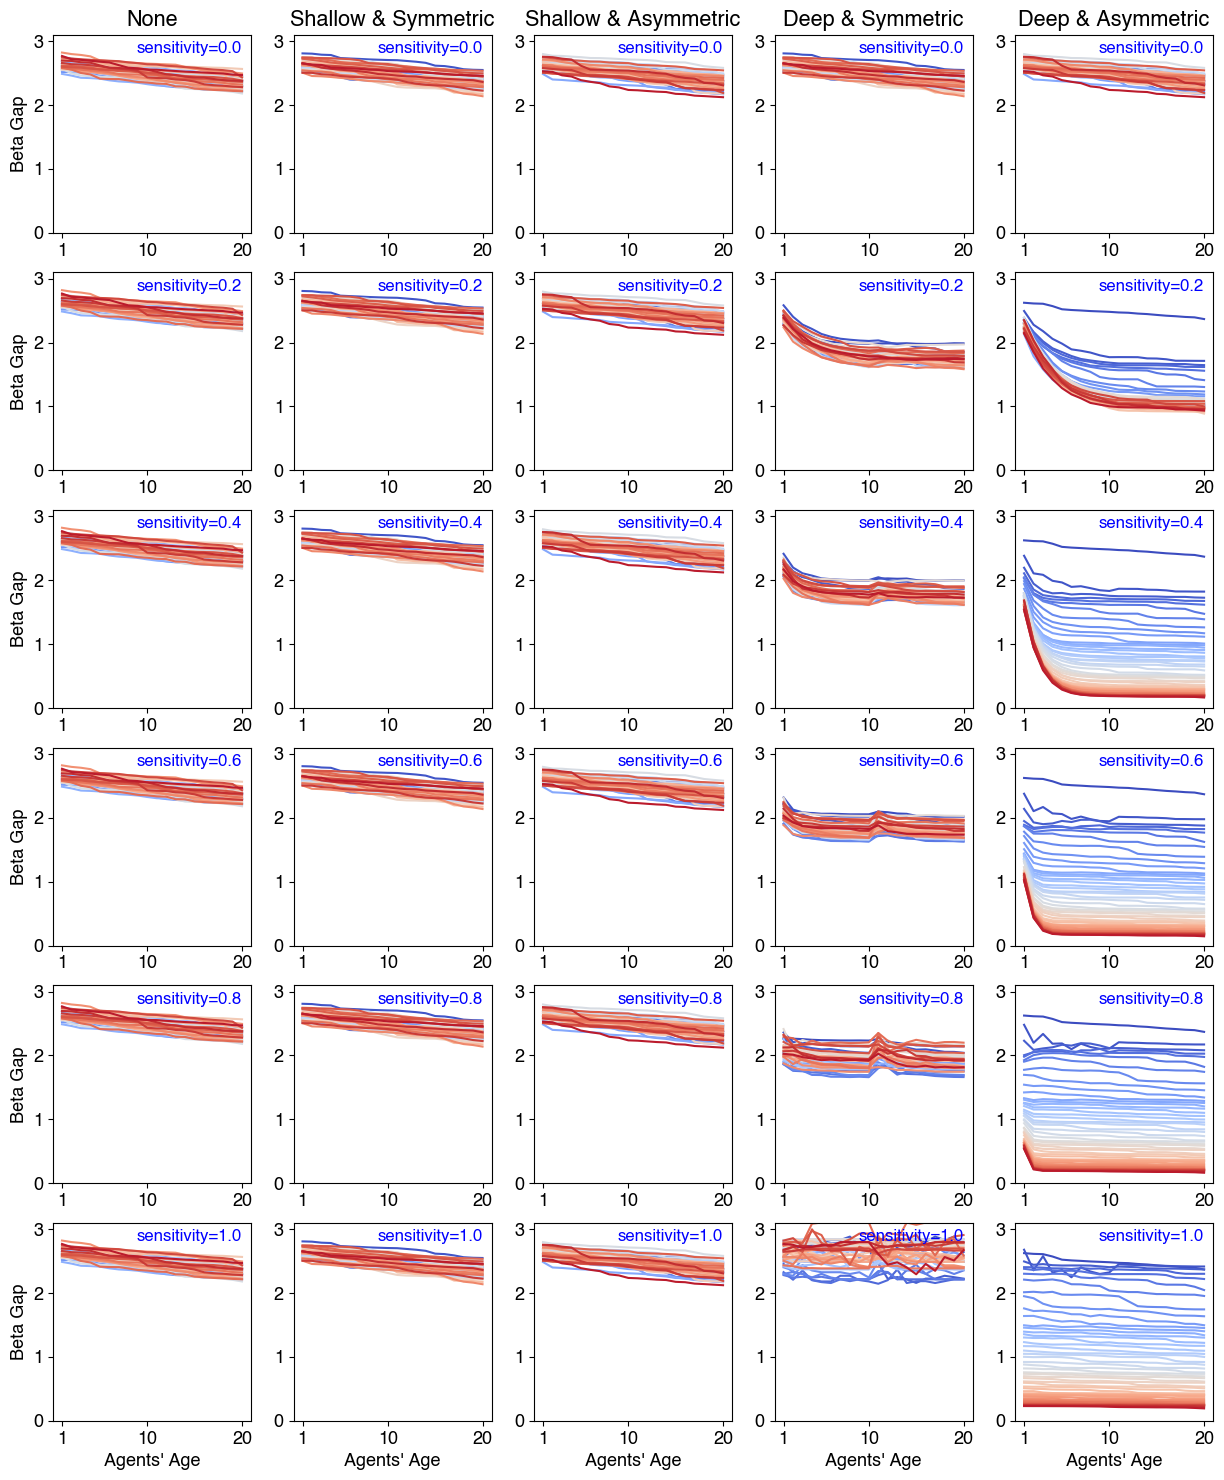

In [16]:
sens = sensitivity_analysis('sensitivity', np.arange(0, 1.1, .2))
plot_sensitivity_analysis(sens)

/var/folders/zh/h1khb7411lv13bh3mcjtr4d80000gn/T/ipykernel_26882/1546748411.py:3: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


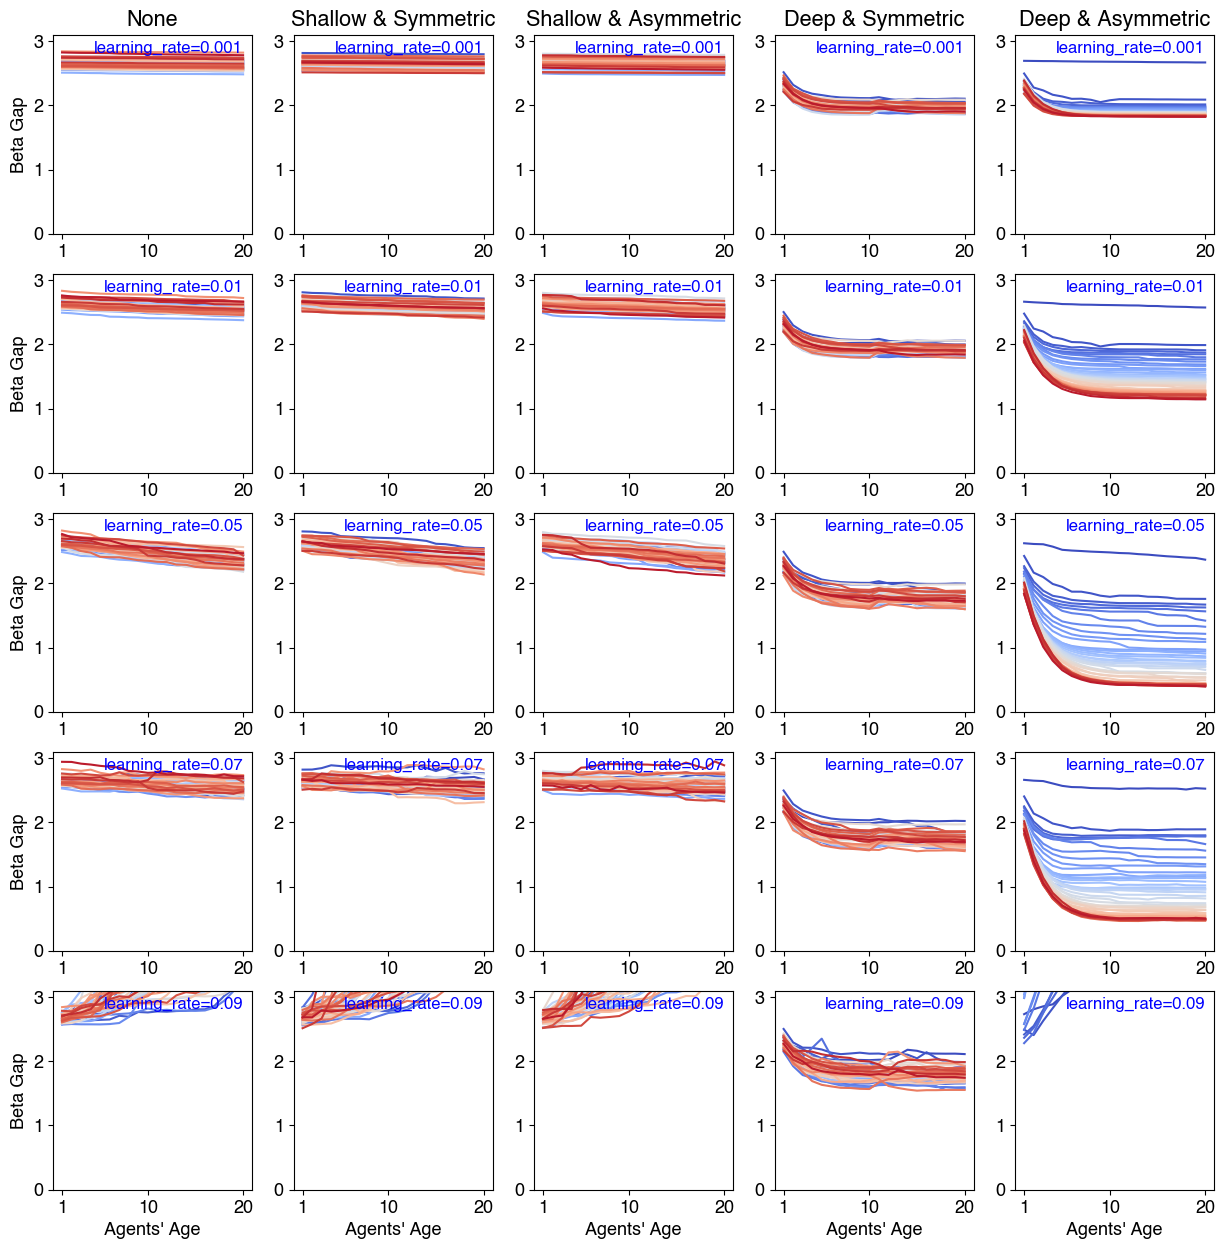

In [17]:
leaning_rate = sensitivity_analysis('learning_rate', [.001, .01, .05, .07, .09])
plot_sensitivity_analysis(leaning_rate)

## Prepare Social Information Using Pilot Data

In [18]:
pilot_df = pd.read_csv("./data/pilot.csv", index_col=0)
pilot_df.head()

,participantId,condition,phase,trial,estimate,questionId,label,area,distance,age,socialInfo,rentTruth,manipulationCheck,residentialExperience,gender,participantAge
0,j52x7ovk6xtp7h7,expert,1,1,20.8,16,コーポ内藤,16.1,2,22,11.2,11.1,3,2,male,22
1,j52x7ovk6xtp7h7,expert,1,2,9.1,11,ふたばハイツ,10.9,5,35,7.5,6.8,3,2,male,22
2,j52x7ovk6xtp7h7,expert,1,3,9.3,5,レジデンス三葉,10.5,6,37,7.2,7.0,3,2,male,22
3,j52x7ovk6xtp7h7,expert,1,4,15.0,9,はまなすレイクビュー,15.8,4,24,10.7,8.7,3,2,male,22
4,j52x7ovk6xtp7h7,expert,1,5,13.8,19,ファイブスター後楽園,12.5,2,23,9.4,10.1,3,2,male,22


In [19]:
pilot_df_participant = (
    pilot_df[['participantId', 'condition', 'manipulationCheck', 'residentialExperience', 'gender', 'participantAge']].drop_duplicates()
    .reset_index(drop=True)
)
pilot_df_participant.head()

,participantId,condition,manipulationCheck,residentialExperience,gender,participantAge
0,j52x7ovk6xtp7h7,expert,3,2,male,22
1,cq56rxkkq87fl64,expert,3,2,female,23
2,ldjyh0qtgsgkez6,expert,6,3,female,22
3,5e4rju6o4b8th3w,expert,5,3,female,20
4,o9dhcpwxgvwuka6,expert,6,3,male,22


In [20]:
# Limit to those who have ever searched apartments by themselves
source_pids = pilot_df_participant[lambda x: x.residentialExperience.isin([1, 2])].participantId.values
print(source_pids)

['j52x7ovk6xtp7h7' 'cq56rxkkq87fl64' '7l2jrlcnhb3t0px' 'gvlts740j5h8ebn']


In [21]:
# Choose 1st stage data
pilot_mean_df = (
    pilot_df[lambda x: (x.participantId.isin(source_pids)) & (x.phase == 1)]
    .groupby(['questionId', 'age', 'area', 'distance', 'rentTruth'])
    .agg({'estimate': 'mean'})
    .reset_index()
)

X = pilot_mean_df[["age", "area", "distance"]]
y = pilot_mean_df["estimate"]

reg = LinearRegression().fit(X, y)
pilot_mean_df["pred"] = reg.predict(X)
pilot_mean_df.head()

,questionId,age,area,distance,rentTruth,estimate,pred
0,0,18,7.3,5,5.9,8.175,9.347297
1,1,44,8.7,2,6.0,7.000,6.616650
2,2,19,21.3,5,14.5,16.475,15.915222
3,3,46,18.4,4,8.5,9.225,10.874651
4,4,33,13.0,5,7.5,9.725,10.017199


# Analysis of Experimental Results

In [22]:
exp_df = pd.read_csv("./data/main.csv", index_col=0)
exp_df.head()

,participantId,condition,phase,trial,estimate,questionId,label,area,distance,age,socialInfo,rentTruth,manipulationCheck,residentialExperience,gender,participantAge
0,dhps19hah2f4fzq,novice,1,1,12.4,20,ジャスミンガーデンズ東大前,14.7,8,19,12.6,10.1,4,3,female,21
1,dhps19hah2f4fzq,novice,1,2,9.0,1,ファイブスター後楽園,8.7,2,44,6.6,6.0,4,3,female,21
2,dhps19hah2f4fzq,novice,1,3,9.2,4,レジデンス三葉,13.0,5,33,10.0,7.5,4,3,female,21
3,dhps19hah2f4fzq,novice,1,4,16.3,2,さくらヒルズレジデンス,21.3,5,19,15.9,14.5,4,3,female,21
4,dhps19hah2f4fzq,novice,1,5,10.9,15,あじさいテラス,15.1,5,19,12.9,12.0,4,3,female,21


In [23]:
p_info_df = (
    exp_df[['participantId', 'condition', 'manipulationCheck', 'residentialExperience', 'gender', 'participantAge']].drop_duplicates()
    .reset_index(drop=True)
)
p_info_df['manipulationCheck'] = -p_info_df['manipulationCheck'] + 7
p_info_df.head()

,participantId,condition,manipulationCheck,residentialExperience,gender,participantAge
0,dhps19hah2f4fzq,novice,3,3,female,21
1,6h3k3qqw18ykdvq,expert,5,3,male,20
2,97sgehrgpnmx2a6,expert,2,1,male,20
3,xo490ppnf2uv9z8,novice,2,2,male,21
4,zppb9orx9ku5w02,expert,4,3,male,20


In [24]:
p_info_df.gender.value_counts()

gender
male      26
female    17
Name: count, dtype: int64

In [25]:
p_info_df.participantAge.describe()

count    43.000000
mean     20.279070
std       0.881708
min      19.000000
25%      20.000000
50%      20.000000
75%      21.000000
max      23.000000
Name: participantAge, dtype: float64

In [26]:
pivot_df = (
    exp_df.pivot_table(index=['participantId', 'condition', 'questionId'], columns='phase', values='estimate')
    .rename(columns={1: "first_estimate", 2: "social_prediction", 3: "second_estimate"})
    .reset_index()
)

q_info_df = (
    exp_df[['questionId', 'area', 'distance', 'age', 'socialInfo', 'rentTruth']].drop_duplicates()
    .sort_values('questionId')
    .reset_index(drop=True)
)

pivot_df.columns.name = None
pivot_df['isin_social'] = pivot_df['social_prediction'].notna()
pivot_df = pivot_df.merge(q_info_df, on="questionId")
pivot_df['advice_gap'] = pivot_df['socialInfo'] - pivot_df['first_estimate']
pivot_df['sensitivity'] = pivot_df.apply(lambda x: (x.second_estimate - x.first_estimate) / x.advice_gap if x.advice_gap != 0 else np.nan, axis=1)
pivot_df = pivot_df[lambda x: x.sensitivity.between(-1, 2, inclusive='both')]
pivot_df

,participantId,condition,questionId,first_estimate,social_prediction,second_estimate,isin_social,area,distance,age,socialInfo,rentTruth,advice_gap,sensitivity
0,1p3u2kc8wqgyeb8,expert,0,10.5,11.0,10.5,True,7.3,5,18,9.3,5.9,-1.2,-0.000000
1,1p3u2kc8wqgyeb8,expert,1,8.8,8.3,8.2,True,8.7,2,44,6.6,6.0,-2.2,0.272727
2,1p3u2kc8wqgyeb8,expert,2,15.3,16.3,15.5,True,21.3,5,19,15.9,14.5,0.6,0.333333
3,1p3u2kc8wqgyeb8,expert,3,7.8,9.0,9.5,True,18.4,4,46,10.9,8.5,3.1,0.548387
4,1p3u2kc8wqgyeb8,expert,4,11.5,NaN,10.3,False,13.0,5,33,10.0,7.5,-1.5,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,zppb9orx9ku5w02,expert,19,13.0,13.5,12.0,True,12.5,2,23,11.3,10.1,-1.7,0.588235
1028,zppb9orx9ku5w02,expert,20,12.0,13.5,12.5,True,14.7,8,19,12.6,10.1,0.6,0.833333
1029,zppb9orx9ku5w02,expert,21,16.0,NaN,16.5,False,15.8,7,8,14.7,14.5,-1.3,-0.384615
1030,zppb9orx9ku5w02,expert,22,13.0,12.0,12.0,True,12.6,4,22,11.4,9.4,-1.6,0.625000


In [27]:
agg_pivot_df = (
    pivot_df
    .groupby(['participantId', 'condition', 'isin_social'])['sensitivity'].agg(['mean', 'count']).reset_index()
    .merge(p_info_df, on='participantId')
)
agg_pivot_df

,participantId,condition_x,isin_social,mean,count,condition_y,manipulationCheck,residentialExperience,gender,participantAge
0,1p3u2kc8wqgyeb8,expert,False,0.222124,9,expert,4,3,male,22
1,1p3u2kc8wqgyeb8,expert,True,0.497389,11,expert,4,3,male,22
2,24ajbskdttx5eeo,expert,False,0.497780,12,expert,4,2,female,20
3,24ajbskdttx5eeo,expert,True,0.571252,12,expert,4,2,female,20
4,2gco68qpnnscppe,expert,False,0.368155,8,expert,2,2,male,20
...,...,...,...,...,...,...,...,...,...,...
81,yrhu178xydh1ndt,novice,True,0.416200,12,novice,2,2,male,22
82,z0qlcw250l6a111,novice,False,0.196043,12,novice,3,3,female,21
83,z0qlcw250l6a111,novice,True,0.395240,12,novice,3,3,female,21
84,zppb9orx9ku5w02,expert,False,0.555357,11,expert,4,3,male,20


## Figure 3:    

In [28]:
sensitivity_df = (
    pivot_df.groupby(['participantId', 'isin_social'])
    .sensitivity.mean()
    .unstack()
    .rename(columns={False: "without_ref_sensitivity", True: "with_ref_sensitivity"})
)
sensitivity_df.head()

isin_social,without_ref_sensitivity,with_ref_sensitivity
participantId,,
1p3u2kc8wqgyeb8,0.222124,0.497389
24ajbskdttx5eeo,0.497780,0.571252
2gco68qpnnscppe,0.368155,0.432485
4r2ylq5yd4tsfsp,0.057105,0.229476
52v6dzcjbqdbsuj,-0.072096,-0.042948


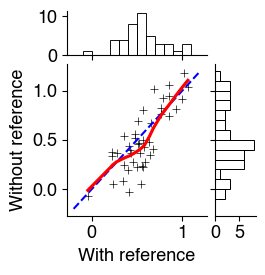

In [29]:
g = sns.jointplot(
    data=sensitivity_df, x='with_ref_sensitivity', y='without_ref_sensitivity',
    ratio=3, marker='+', color='k', height=3, marginal_ticks=True,
    marginal_kws=dict(bins=[i/10 for i in range(-2, 13)], fill=False)
)
g.ax_joint.plot([-.2, 1.2], [-.2, 1.2], 'b--')
sns.regplot(
    x='with_ref_sensitivity', y='without_ref_sensitivity', data=sensitivity_df, lowess=True, ax=g.ax_joint,
    scatter_kws={"color": "w", 'alpha': 0}, line_kws={"color": "red"}
)
g.ax_joint.set_xlabel("With reference")
g.ax_joint.set_ylabel("Without reference")
plt.savefig("img/fig3.pdf")
plt.show()
plt.close()

## Stats

In [33]:
d = pivot_df.copy()
d["condition"] = d["condition"].map({"novice": 0, "expert": 1})
d["isin_social"] = d["isin_social"].map({True: 1, False: 0})
d["interaction_term"] = d["isin_social"] * d["condition"]
d["intercept"] = 1

Y = d["sensitivity"].values
X = d[["isin_social", "condition", "interaction_term", "intercept"]].values
Group = d[["questionId", "participantId"]].values

model = gpb.GPModel(group_data=Group, likelihood="gaussian")
model.fit(y=Y, X=X, params={"std_dev": True})
model.summary()
model.get_coef()


Model summary:
 Log-lik     AIC    BIC
 -600.56 1215.11 1249.0
Nb. observations: 936
Nb. groups: 24 (Group_1), 43 (Group_2)
-----------------------------------------------------
Covariance parameters (random effects):
            Param.  Std. dev.
Error_term  0.1917     0.0092
Group_1     0.0013     0.0019
Group_2     0.0558     0.0140
-----------------------------------------------------
Linear regression coefficients (fixed effects):
             Param.  Std. dev.  z value  P(>|z|)
Covariate_1  0.0804     0.0392   2.0504   0.0403
Covariate_2  0.0682     0.0835   0.8159   0.4145
Covariate_3 -0.0437     0.0578  -0.7573   0.4489
Covariate_4  0.4698     0.0574   8.1816   0.0000


,Covariate_1,Covariate_2,Covariate_3,Covariate_4
Param.,0.080438,0.068152,-0.043749,0.469751
Std. dev.,0.039230,0.083526,0.057772,0.057416


In [34]:
cred_high = p_info_df.query('condition == "expert"').manipulationCheck.values
cred_low = p_info_df.query('condition == "novice"').manipulationCheck.values

print(pd.DataFrame(pd.Series(cred_high.ravel()).describe()).transpose())
print(pd.DataFrame(pd.Series(cred_low.ravel()).describe()).transpose())

ttest_ind(cred_high, cred_low, equal_var=False)


   count  mean       std  min  25%  50%  75%  max
0   20.0   3.8  1.056309  2.0  3.0  4.0  5.0  5.0
   count      mean      std  min  25%  50%  75%  max
0   23.0  3.434783  1.44052  0.0  3.0  3.0  4.5  6.0


TtestResult(statistic=0.9557810651826022, pvalue=0.344932808069207, df=39.93777985443778)

In [35]:
d = pivot_df.merge(p_info_df.drop("condition", axis=1), on="participantId")
d["condition"] = d["condition"].map({"novice": 0, "expert": 1})
d["isin_social"] = d["isin_social"].map({True: 1, False: 0})
d["manipulationCheck"] = (d["manipulationCheck"] - np.mean(d["manipulationCheck"])) / np.std(d["manipulationCheck"])
d = d[d.sensitivity.between(-1, 2, inclusive="both")]
d["interaction_term"] = d["isin_social"] * d["manipulationCheck"]
d["intercept"] = 1

Y = d["sensitivity"].values
X = d[["isin_social", "manipulationCheck", "interaction_term", "intercept"]].values
Group = d[["questionId", "participantId"]].values

model = gpb.GPModel(group_data=Group, likelihood="gaussian")
model.fit(y=Y, X=X, params={"std_dev": True})
model.summary()
model.get_coef()


Model summary:
 Log-lik     AIC     BIC
 -594.14 1202.29 1236.18
Nb. observations: 936
Nb. groups: 24 (Group_1), 43 (Group_2)
-----------------------------------------------------
Covariance parameters (random effects):
            Param.  Std. dev.
Error_term  0.1917     0.0092
Group_1     0.0014     0.0019
Group_2     0.0387     0.0103
-----------------------------------------------------
Linear regression coefficients (fixed effects):
             Param.  Std. dev.  z value  P(>|z|)
Covariate_1  0.0609     0.0288   2.1116   0.0347
Covariate_2  0.1411     0.0368   3.8333   0.0001
Covariate_3 -0.0142     0.0288  -0.4940   0.6213
Covariate_4  0.5000     0.0374  13.3770   0.0000


,Covariate_1,Covariate_2,Covariate_3,Covariate_4
Param.,0.060886,0.141126,-0.014245,0.500050
Std. dev.,0.028833,0.036816,0.028834,0.037381


In [37]:
mean_sensitivity = (
    pivot_df
    .pivot_table(index=["participantId"], columns=["isin_social"], values="sensitivity", aggfunc="mean")
)
d = mean_sensitivity.reset_index().rename(columns={True: "sensitivity_with", False: "sensitivity_without"})
sensitivity_with = d.sensitivity_with.values
sensitivity_without = d.sensitivity_without.values

cor, p = spearmanr(sensitivity_with, sensitivity_without)

print("Spearman's correlation coefficient: {:.3f}".format(cor))
print("p-value: {:.3f}".format(p))


Spearman's correlation coefficient: 0.721
p-value: 0.000
